In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import tensorflow as tf
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

In [4]:
import utils_rich_mrartemev
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
utils_rich = utils_rich_mrartemev
particles = ['kaon', 'pion', 'proton', 'muon']

In [8]:
data_full = {
    particle : utils_rich.load_and_merge_and_cut(utils_rich.datasets[particle])
    for particle in particles
}

In [9]:
from collections import namedtuple
DataSplits = namedtuple("DataSplits", ['train', 'val', 'test'])

In [10]:
import os

In [11]:
models_path = "/home/martemev/data/Lambda/RICH-GAN/research/exported_model/"
preprocessors_path = "/home/martemev/data/Lambda/RICH-GAN/research/preprocessors/"

model_name_format = "FastFastRICH_Cramer_{}"
preprocessor_name_format = "FastFastRICH_Cramer_{}_preprocessor.pkl"

In [12]:
from sklearn.externals import joblib

In [13]:
def transform(arr, scaler, inverse=False):
    t = scaler.inverse_transform if inverse else scaler.transform
    XY_t = t(arr[:,:-1])
    W = arr[:,-1:]
    return np.concatenate([XY_t, W], axis=1)

for particle in particles:
    with tf.Session(config=tf_config) as sess:
        predictor = tf.contrib.predictor.from_saved_model(
            os.path.join(models_path, model_name_format.format(particle))
        )
        scaler = joblib.load(
            os.path.join(preprocessors_path, preprocessor_name_format.format(particle))
        )
        
        data_full_t = transform(data_full[particle].values, scaler)
        
        predictions_t = predictor({'x' : data_full_t[:,utils_rich.y_count:]})['dlls']
        data_full_t[:,:utils_rich.y_count] = predictions_t
        data_full_predicted = transform(data_full_t, scaler, inverse=True)
        
        for i, col in enumerate(utils_rich.dll_columns):
            data_full[particle]["predicted_{}".format(col)] = data_full_predicted[:,i]

INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_kaon/variables/variables


/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_pion/variables/variables


/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_proton/variables/variables


/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


INFO:tensorflow:Restoring parameters from /home/martemev/data/Lambda/RICH-GAN/research/exported_model/FastFastRICH_Cramer_muon/variables/variables


/mnt/amaevskiy/conda_env/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
splits = {
    particle : DataSplits(*utils_rich.split(data_full[particle]))
    for particle in particles
}

In [21]:
pd.to_pickle(splits, 'test.pkl')

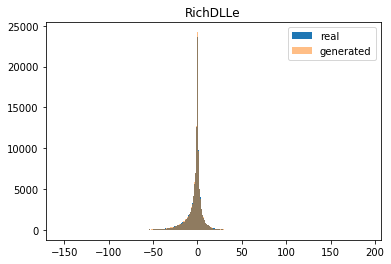

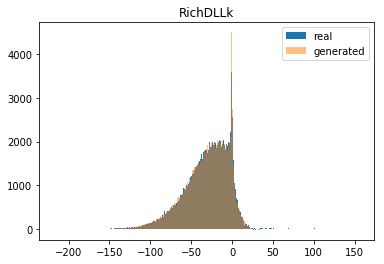

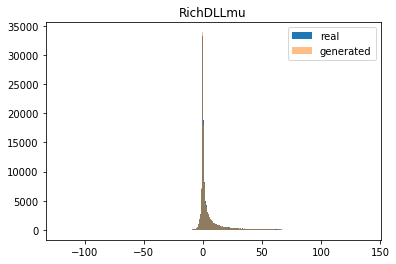

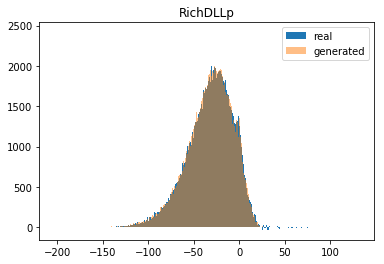

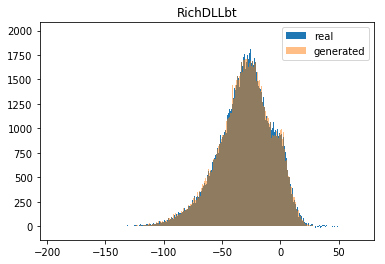

In [15]:
df = splits['muon'].test

def get_range(*arrays):
    left  = min(arr.min() for arr in arrays)
    right = max(arr.max() for arr in arrays)
    return left, right

for col in utils_rich.dll_columns:
    col_predicted = "predicted_{}".format(col)
    bins = np.linspace(*get_range(df[col], df[col_predicted]), 500)
    plt.hist(df[col          ], bins=bins, weights=df[utils_rich.weight_col], label='real')
    plt.hist(df[col_predicted], bins=bins, weights=df[utils_rich.weight_col], label='generated', alpha=0.5)
    plt.legend()
    plt.title(col)
    plt.show()
    